In [24]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [3]:
os.chdir("D://BIT_study_related//Thesis//Data_Monthly")

In [11]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
df = pd.read_csv('CO2_date_index.csv',index_col='Months',parse_dates=['Months'], date_parser=dateparse)
df.drop('Unnamed: 0',axis=1,inplace=True)
df

C:\Users\shrey\AppData\Local\Temp\ipykernel_6444\2628453698.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')


,mean
Months,
2014-11-01,395.637395
2014-12-01,397.559220
2015-01-01,397.419025
2015-02-01,398.980959
2015-03-01,399.970865
...,...
2022-10-01,413.995709
2022-11-01,416.944042
2022-12-01,417.970509


<Axes: xlabel='Months'>

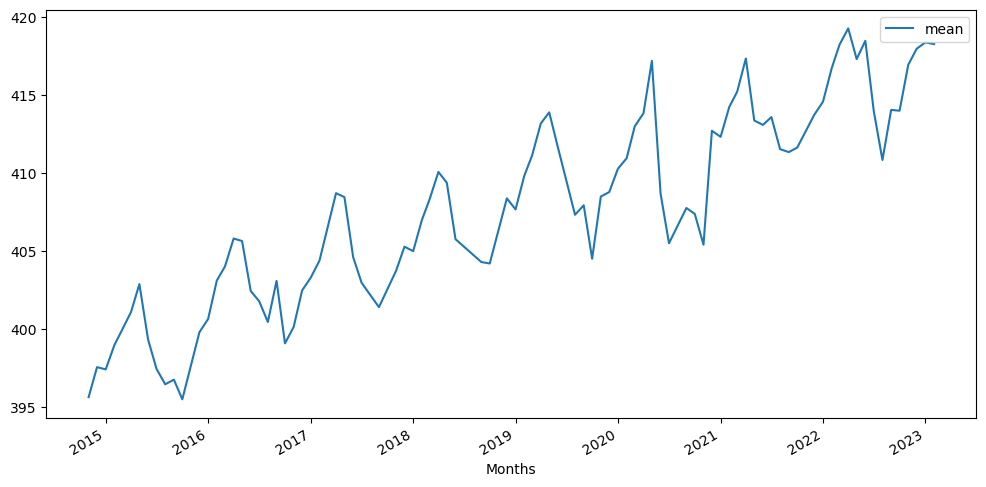

In [13]:
df.plot(figsize=(12,6))

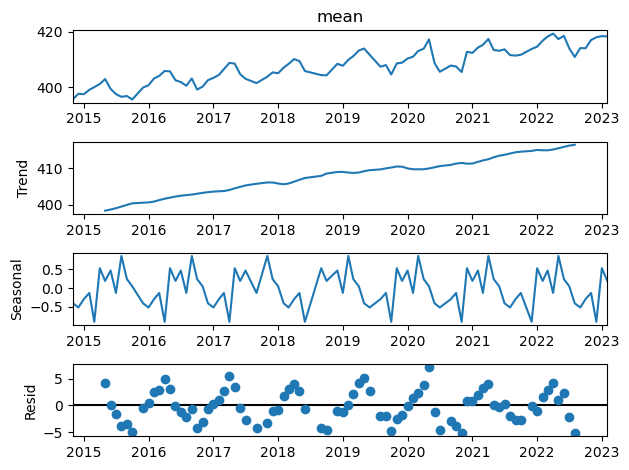

In [14]:
results = seasonal_decompose(df['mean'],period=12)
results.plot();

In [15]:
len(df)

91

In [16]:
train = df.iloc[:81]
test = df.iloc[81:]
scaler = MinMaxScaler()

In [17]:
df.head(),df.tail()

(                  mean
 Months                
 2014-11-01  395.637395
 2014-12-01  397.559220
 2015-01-01  397.419025
 2015-02-01  398.980959
 2015-03-01  399.970865,
                   mean
 Months                
 2022-10-01  413.995709
 2022-11-01  416.944042
 2022-12-01  417.970509
 2023-01-01  418.375288
 2023-02-01  418.269817)

In [18]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [19]:
scaled_train[:10]

array([[0.00583656],
       [0.08666905],
       [0.08077239],
       [0.14646777],
       [0.18810348],
       [0.23511106],
       [0.31056215],
       [0.16102159],
       [0.082209  ],
       [0.04044467]])

In [20]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [21]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.00583656 0.08666905 0.08077239]
Predict this y: 
 [[0.14646777]]


In [22]:
X.shape

(1, 3, 1)

In [23]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [25]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [27]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
69/69 [==============================] - 2s 6ms/step - loss: 0.0842
Epoch 2/50
69/69 [==============================] - 0s 5ms/step - loss: 0.0157
Epoch 3/50
69/69 [==============================] - 0s 5ms/step - loss: 0.0159
Epoch 4/50
69/69 [==============================] - 0s 5ms/step - loss: 0.0129
Epoch 5/50
69/69 [==============================] - 0s 5ms/step - loss: 0.0132
Epoch 6/50
69/69 [==============================] - 0s 5ms/step - loss: 0.0144
Epoch 7/50
69/69 [==============================] - 0s 5ms/step - loss: 0.0106
Epoch 8/50
69/69 [==============================] - 0s 5ms/step - loss: 0.0128
Epoch 9/50
69/69 [==============================] - 0s 5ms/step - loss: 0.0141
Epoch 10/50
69/69 [==============================] - 0s 5ms/step - loss: 0.0109
Epoch 11/50
69/69 [==============================] - 0s 5ms/step - loss: 0.0109
Epoch 12/50
69/69 [==============================] - 0s 5ms/step - loss: 0.0083
Epoch 13/50
69/69 [==============================

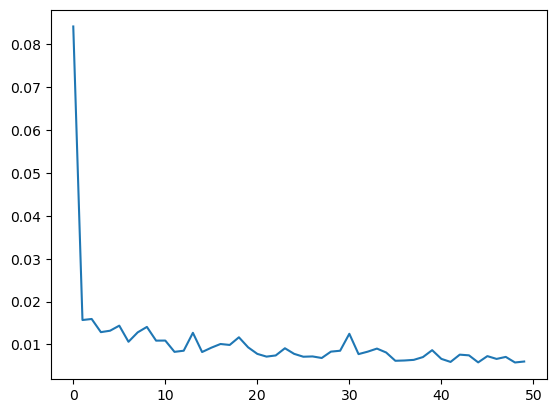

In [28]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [29]:
last_train_batch = scaled_train[-12:]

In [30]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [31]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 290ms/step


array([[1.0097154]], dtype=float32)

In [32]:
scaled_test[0]

array([0.91731155])

In [33]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 24ms/step


In [34]:
test_predictions

[array([1.0097154], dtype=float32),
 array([0.9545617], dtype=float32),
 array([0.89371896], dtype=float32),
 array([0.86721087], dtype=float32),
 array([0.8847753], dtype=float32),
 array([0.9351482], dtype=float32),
 array([1.0052118], dtype=float32),
 array([1.0834358], dtype=float32),
 array([1.1584576], dtype=float32),
 array([1.2236669], dtype=float32)]

In [35]:
test.head()

,mean
Months,
2022-05-01,417.308083
2022-06-01,418.477850
2022-07-01,413.978206
2022-08-01,410.837089
2022-09-01,414.051096


In [36]:
true_predictions = scaler.inverse_transform(test_predictions)

In [37]:
test['Predictions'] = true_predictions

C:\Users\shrey\AppData\Local\Temp\ipykernel_6444\4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<Axes: xlabel='Months'>

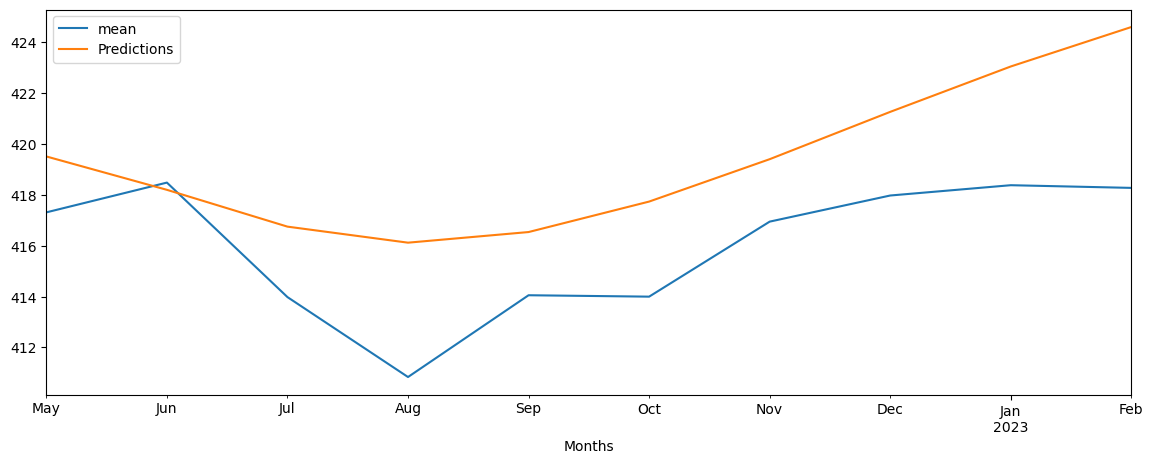

In [38]:
test.plot(figsize=(14,5))

In [41]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['mean'],test['Predictions']))
print(rmse)

3.7302477104850618
